In [150]:
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
import os.path
import subprocess
import pickle
import pandas as pd
from MDAnalysis.analysis import distances
import sys
import math

## Will do this for each efflux and influx in this script, so we can keep results here and images. For efflux, go [down](#efflux)

In [151]:
indir = '../../state_by_state_running/targeted_MD/influx_apo_all_heavy/OutOpen-InOpen'

u = mda.Universe(f'{indir}/OUT.equilib.200ns.gro',\
                           f'{indir}/OutOpen-InOpen.TMD_only.noskip.xtc')

In [152]:
gate_EC = [(30,37), (289,295)]
gate_IC = [(136,145), (386,394)]

def get_tm_COM(md_uni):
    tm1 = md_uni.select_atoms('resid %i-%i' %(gate_EC[0][0], gate_EC[0][1])).center_of_mass()
    tm7 = md_uni.select_atoms('resid %i-%i' %(gate_EC[1][0], gate_EC[1][1])).center_of_mass()
    tm4 = md_uni.select_atoms('resid %i-%i' %(gate_IC[0][0], gate_IC[0][1])).center_of_mass()
    tm10 = md_uni.select_atoms('resid %i-%i' %(gate_IC[1][0], gate_IC[1][1])).center_of_mass()    

    return tm1,tm7,tm4,tm10

In [153]:
gate_EC_dists = []
gate_IC_dists = []

for timestep in u.trajectory:
    tm1,tm7,tm4,tm10 = get_tm_COM(u)

    gate_EC_dists.append(float(distances.distance_array(tm1, tm7)) / 10)
    gate_IC_dists.append(float(distances.distance_array(tm4, tm10))/ 10) #keep in nm

    
gate_EC_dists = np.array(gate_EC_dists)
gate_IC_dists = np.array(gate_IC_dists)

Plot the entire trajectory first

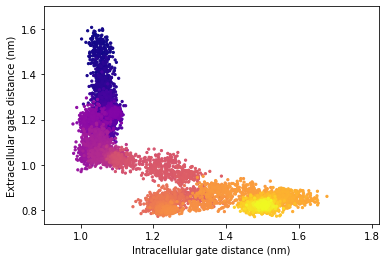

In [154]:
a = 1
s = 5
cmap = plt.cm.get_cmap('plasma')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists)))


#plt.scatter(gate_IC_dists_influx[[112,220,302,408]], gate_EC_dists_influx[[112,220,302,408]],\
#            alpha = 1, color = 'green', s=100, edgecolor = 'black')

fig, ax = plt.subplots()
im = ax.scatter(gate_IC_dists, gate_EC_dists, alpha = a, color = colormap, s = s)
#fig.colorbar(im, ax=ax)

plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")
plt.show()

Can take equal points along the sim to get your start for strings, but this is not the best idea, because sampling will be different for each chunk of TMD

<ipython-input-155-79598c868f16>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  colormap = colormap[[equal_indices]]
<ipython-input-155-79598c868f16>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(gate_IC_dists[[equal_indices]], gate_EC_dists[[equal_indices]], s = 100, color = colormap)


Text(0.5, 0, 'Intracellular gate distance (nm)')

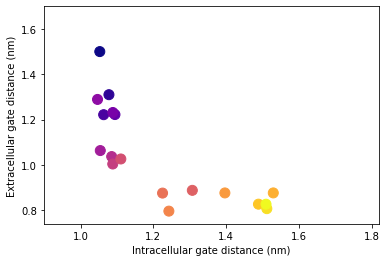

In [155]:
equal_indices = np.round(np.linspace(0, len(gate_IC_dists)-1, 18))
equal_indices = np.array(equal_indices, dtype = int)

cmap = plt.cm.get_cmap('plasma')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists)))
colormap = colormap[[equal_indices]]

plt.scatter(gate_IC_dists[[equal_indices]], gate_EC_dists[[equal_indices]], s = 100, color = colormap)
plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")

Influx:

**Out Open - Out Occ** - 10550ps (frame 0 - 2637)


**Out Occ - Occ** - 10800ps (frame 2637-5337)

**Occ - In Occ** - 7680ps (frame 5337-7257)

**In Occ - In Open** - 10770ps (frame 7257 - 9950)

I think the best assumption is to take 4 beads from each transition. Each transition might not actually be this equal in 'real time' (ie Out Open --> Out Occ takes no time at all, but you are 'oversampling' this area by having 4 points there, but since we have no way of knowing this so we just have to try. 

The points you should take for sure are:
0, 2637, 5337, 7257, and ~~9950~~. (**9859** instead, is not end of sim but is closest to in open) That leaves 11 more to choose from. Try to take from start of TMD since the traj will be probably more in between the two states, whereas near the end of TMD it's very close

Take 2 from Out Open - Out Occ (500 & 1000)

Take 3 from Out Occ - Occ (2800, 3200, 4200)

Take 3 from Occ - In Occ (5500, 5750, 6300)

Take 3 InOcc - In Open (7350, 7700, 9100)

Only one I am not sure of is InOcc-InOpen. If I take 8000, for this is more open on IC than IN.start.gro. Should I take this as endpoint instead??

Text(0.5, 0, 'Intracellular gate distance (nm)')

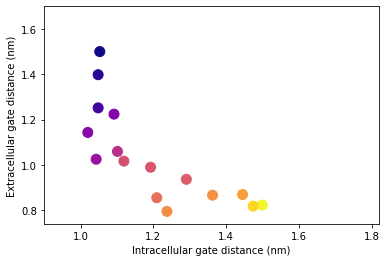

In [156]:
sarah_indices = [0, 2637, 5337, 7257, 9859,\
                 500, 1000, \
                 2800, 3200, 4200, \
                 5500, 5750, 6300, \
                7350, 7700, 9100]

cmap = plt.cm.get_cmap('plasma')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists)))
colormap = colormap[sarah_indices]

plt.scatter(gate_IC_dists[sarah_indices], gate_EC_dists[sarah_indices], s = 100, color = colormap)

plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")

In [157]:
sarah_indices_influx = sarah_indices
IC_inf = gate_IC_dists
EC_inf = gate_EC_dists

<a id='efflux'></a>


## Efflux simulations. Same process as above

In [158]:
indir = '../../state_by_state_running/targeted_MD/efflux_apo_all_heavy/InOpen-OutOpen'

u = mda.Universe(f'{indir}/IN.start.gro',\
                           f'{indir}/InOpen-OutOpen.xtc')

In [159]:
gate_EC_dists = []
gate_IC_dists = []

for timestep in u.trajectory:
    tm1,tm7,tm4,tm10 = get_tm_COM(u)

    gate_EC_dists.append(float(distances.distance_array(tm1, tm7)) / 10)
    gate_IC_dists.append(float(distances.distance_array(tm4, tm10))/ 10) #keep in nm

    
gate_EC_dists = np.array(gate_EC_dists)
gate_IC_dists = np.array(gate_IC_dists)


Plot the entire trajectory first:

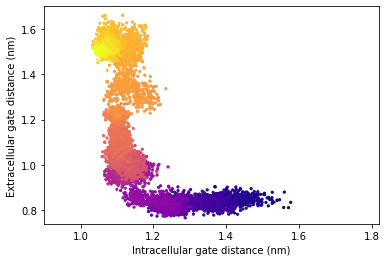

In [160]:
a = 1
s = 5
cmap = plt.cm.get_cmap('plasma')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists)))


#plt.scatter(gate_IC_dists_influx[[112,220,302,408]], gate_EC_dists_influx[[112,220,302,408]],\
#            alpha = 1, color = 'green', s=100, edgecolor = 'black')

fig, ax = plt.subplots()
im = ax.scatter(gate_IC_dists, gate_EC_dists, alpha = a, color = colormap, s = s)
#fig.colorbar(im, ax=ax)

plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")
plt.show()

Can take equal points along the sim to get your start for strings, but this is not the best idea, because sampling will be different for each chunk of TMD

<ipython-input-161-79598c868f16>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  colormap = colormap[[equal_indices]]
<ipython-input-161-79598c868f16>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(gate_IC_dists[[equal_indices]], gate_EC_dists[[equal_indices]], s = 100, color = colormap)


Text(0.5, 0, 'Intracellular gate distance (nm)')

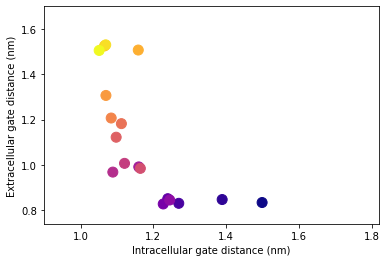

In [161]:
equal_indices = np.round(np.linspace(0, len(gate_IC_dists)-1, 18))
equal_indices = np.array(equal_indices, dtype = int)

cmap = plt.cm.get_cmap('plasma')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists)))
colormap = colormap[[equal_indices]]

plt.scatter(gate_IC_dists[[equal_indices]], gate_EC_dists[[equal_indices]], s = 100, color = colormap)
plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")

Efflux:

**In Open - In Occ** - 9632 ps (frame 0-2407)


**In Occ - Occ** - 8628 ps (frame 2407-4563)

**Occ - Out Occ** - 7772 ps (frame 4563-6505)

**Out Occ - Out Open** - 9136 ps (frame 6505-8789)

I think the best assumption is to take 4 beads from each transition. Each transition might not actually be this equal in 'real time' (ie Out Open --> Out Occ takes no time at all, but you are 'oversampling' this area by having 4 points there, but since we have no way of knowing this so we just have to try. 

The points you should take for sure are:
0, 2407, 4563, 6505, and 8789. That leaves 11 more to choose from. Try to take from start of TMD since the traj will be probably more in between the two states, whereas near the end of TMD it's very close

Take 3 from InOpen-InOcc (300, 750, 1200)

Take 3 from InOcc-Occ (2600, 3000, 3800)

Take 3 from Occ-OutOcc (5170, 5300, 5700) This one is weird I know, was difficult to get out of occ-outocc, took quite a bit of pushing until EC gate opened

Take 2 from OutOcc-OutOpen (6705, 6850)

In [162]:
len(gate_IC_dists)

8789

Text(0.5, 0, 'Intracellular gate distance (nm)')

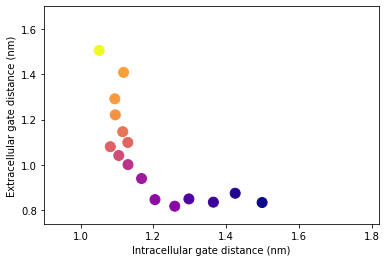

In [163]:
sarah_indices = [0, 2407, 4563, 6505, 8788,\
                300, 750, 1200,\
                2600, 3000, 3800,\
                5170, 5300, 5700, \
                6705, 6850]

cmap = plt.cm.get_cmap('plasma')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists)))
colormap = colormap[sarah_indices]

plt.scatter(gate_IC_dists[sarah_indices], gate_EC_dists[sarah_indices], s = 100, color = colormap)

plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")

In [164]:
sarah_indices_efflux = sarah_indices
IC_eff = gate_IC_dists
EC_eff = gate_EC_dists

Write out these indices for gmx trjconv selections

In [165]:
sarah_indices_efflux = np.array(sarah_indices_efflux)
sarah_indices_influx = np.array(sarah_indices_influx)

print("INFLUX timestamps:", np.sort(sarah_indices_influx) * 4)
print("EFFLUX timestamps:", np.sort(sarah_indices_efflux) * 4)

INFLUX timestamps: [    0  2000  4000 10548 11200 12800 16800 21348 22000 23000 25200 29028
 29400 30800 36400 39436]
EFFLUX timestamps: [    0  1200  3000  4800  9628 10400 12000 15200 18252 20680 21200 22800
 26020 26820 27400 35152]


Now plot the two gates with each other:

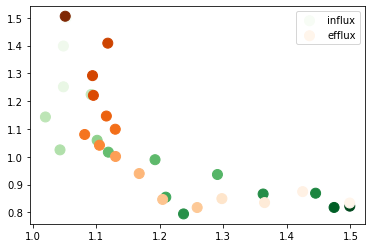

In [170]:
cmap = plt.cm.get_cmap('Greens')
colormap = cmap(np.linspace(0,1, len(IC_inf)))
colormap = colormap[sarah_indices_influx]

plt.scatter(IC_inf[sarah_indices_influx], EC_inf[sarah_indices_influx], s = 100, color = colormap, label = 'influx')




cmap = plt.cm.get_cmap('Oranges')
colormap = cmap(np.linspace(0,1, len(IC_eff)))
colormap = colormap[sarah_indices_efflux]

plt.scatter(IC_eff[sarah_indices_efflux], EC_eff[sarah_indices_efflux], s = 100, color = colormap, label = 'efflux')
plt.legend()

In [167]:
target_IC_inf = np.where(np.logical_and(IC_inf>=1.4987, IC_inf<=1.499))
target_IC_inf

(array([8337, 8462, 8474, 8612, 8638, 8717, 9360, 9515, 9643, 9743, 9806,
        9859, 9895]),)

In [168]:
print(IC_inf[9859], EC_inf[9859], '"In open" influx')
print(IC_inf[9895], EC_inf[9895], '"In open" influx')
print(IC_eff[0], EC_eff[0], 'Actual in open')

#OK so from this analysis, we know now to actually take a different coordinate for sarah_indices_influx

1.4989836041951405 0.8227302016429798 "In open" influx
1.4989499207772619 0.8107581347156531 "In open" influx
1.4987937086433547 0.8339083675081197 Actual in open


In [169]:
sarah_indices_influx

array([   0, 2637, 5337, 7257, 9859,  500, 1000, 2800, 3200, 4200, 5500,
       5750, 6300, 7350, 7700, 9100])